In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

In [15]:
#ae = pd.read_excel('..\data\Sample Data AgencyExpress (1% sample Georgia).xlsx')
amx_lines = pd.read_excel('..\data\Choice Data.xlsx', sheet_name='AMX_OFFER_LINES')
amx_header = pd.read_excel('..\data\Choice Data.xlsx', sheet_name='AMX_OFFER_HEADER')

In [16]:
sp500 = pd.read_csv('..\data\SP500.csv')

In [17]:
amx_lines = amx_lines[['OFFERNUMBER', 'PRODUCTTYPECODE', 'QUANTITY', 'TOTALGROSSWEIGHT']]
print(amx_lines.shape)
amx_header = amx_header[['OFFERNUMBER', 'OFFERDATE']]
print(amx_header.shape)

(359978, 4)
(46509, 2)


In [18]:
sp500['observation_date'] = pd.to_datetime(sp500['observation_date'])
#sp500['QUARTER_YEAR'] = sp500['observation_date'].dt.to_period('Q')
display(sp500)

,observation_date,SP500
0,2015-04-06,2080.62
1,2015-04-07,2076.33
2,2015-04-08,2081.90
3,2015-04-09,2091.18
4,2015-04-10,2102.06
...,...,...
2537,2024-12-25,NaN
2538,2024-12-26,6037.59
2539,2024-12-27,5970.84
2540,2024-12-30,5906.94


In [19]:
amx = pd.merge(amx_lines, amx_header, on='OFFERNUMBER')
display(amx)

,OFFERNUMBER,PRODUCTTYPECODE,QUANTITY,TOTALGROSSWEIGHT,OFFERDATE
0,N059273,BP,21.0,493.50,04/10/2003
1,N059274,COND,231.0,2852.85,04/10/2003
2,N060118,BP,12.0,60.00,04/21/2003
3,N060118,BP,24.0,120.00,04/21/2003
4,N052341,MIX,1441.0,10040.00,02/19/2003
...,...,...,...,...,...
359942,N26060401,DAIRY,1.0,6.56,10/15/2024
359943,N26060401,MEAT,20.0,552.96,10/15/2024
359944,N26060401,DSRT,201.0,660.29,10/15/2024
359945,N26060401,MEAT,30.0,62.22,10/15/2024


In [20]:
amx['OFFERDATE'] = pd.to_datetime(amx['OFFERDATE'])
amx = amx[amx['OFFERDATE'].dt.year >= 2015]
#amx['QUARTER_YEAR'] = amx['OFFERDATE'].dt.to_period('Q')
display(amx)

,OFFERNUMBER,PRODUCTTYPECODE,QUANTITY,TOTALGROSSWEIGHT,OFFERDATE
135957,N6167646,BABY,68.0,394.00,2015-02-26
135958,N6167646,BABY,1265.0,4630.00,2015-02-26
135959,N6167646,BABY,3.0,9.00,2015-02-26
135960,N6167646,BABY,29.0,98.00,2015-02-26
135961,N6167646,BABY,60.0,121.00,2015-02-26
...,...,...,...,...,...
359942,N26060401,DAIRY,1.0,6.56,2024-10-15
359943,N26060401,MEAT,20.0,552.96,2024-10-15
359944,N26060401,DSRT,201.0,660.29,2024-10-15
359945,N26060401,MEAT,30.0,62.22,2024-10-15


In [22]:
amx_grouped = amx.groupby([pd.Grouper(key='OFFERDATE', freq='W'), 'PRODUCTTYPECODE'])['QUANTITY'].sum().reset_index()

amx_pivot = amx_grouped.pivot(index='OFFERDATE', columns='PRODUCTTYPECODE', values='QUANTITY').fillna(0)

display(amx_pivot)

PRODUCTTYPECODE,BABY,BEV,BP,CEREAL,CLEAN,COND,DAIRY,DOUGH,DRESS,DSRT,...,PASTA,PET,PHSE,PPERS,PREPERISH,PRO,RICE,SALVAGE,SNACK,VEG
OFFERDATE,,,,,,,,,,,,,,,,,,,,,
2015-01-11,3664.0,1485.0,44.0,86.0,0.0,0.0,173.0,0.0,590.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1164.0,40.0
2015-01-18,0.0,0.0,0.0,0.0,0.0,653.0,972.0,0.0,1515.0,0.0,...,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,39116.0,0.0
2015-01-25,0.0,6967.0,984.0,10730.0,0.0,57.0,49.0,0.0,0.0,7.0,...,320.0,0.0,0.0,2.0,0.0,644.0,0.0,0.0,26441.0,0.0
2015-02-01,7031.0,7475.0,164.0,8764.0,0.0,593.0,5096.0,0.0,276.0,3489.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,576.0,36507.0,2.0
2015-02-08,0.0,2724.0,672.0,2407.0,0.0,681.0,78.0,0.0,103.0,6565.0,...,0.0,0.0,0.0,0.0,0.0,18743.0,0.0,0.0,2756.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-22,0.0,138.0,0.0,0.0,0.0,109.0,552.0,0.0,171.0,144.0,...,2698.0,2728.0,0.0,0.0,0.0,0.0,2739.0,24.0,4309.0,20948.0
2024-09-29,1470.0,18.0,2.0,0.0,0.0,971.0,166.0,1275.0,216.0,302.0,...,0.0,14353.0,0.0,0.0,0.0,264.0,0.0,0.0,2363.0,10563.0
2024-10-06,2240.0,274.0,893.0,3619.0,0.0,5176.0,7258.0,2336.0,2833.0,250.0,...,6548.0,1723.0,0.0,0.0,0.0,305.0,1017.0,0.0,15205.0,4925.0


In [25]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(data[i + window_size])
    return np.array(sequences), np.array(targets)

In [27]:
X, y = create_sequences(amx_pivot['VEG'].values, 10)

X = X.reshape(X.shape[0], X.shape[1], 1)

In [29]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(10, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=30, verbose=1)
predictions = model.predict(X)

Epoch 1/30


C:\Users\Emma Carrier\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 34927928.0000
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39657832.0000
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26086928.0000
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27781126.0000
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39613432.0000
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22522424.0000
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33112242.0000
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19222414.0000
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34714528.0000
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24814546.0000
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18019548.0000
Epoch 12/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 34822344.0000
Epoch 13/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29831572.0000
Epoch 14/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23777582.000

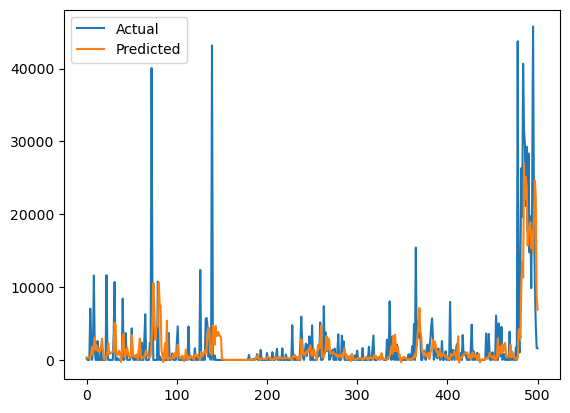

In [30]:
plt.plot(y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()